![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [4]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [7]:
# Celda 1.1
print(bikes.groupby('season').total.mean())

## Análisis adicionales
print("")
print("Análisis de la distribución de observaciones en la variable 'season'")
print(pd.value_counts(bikes['season']))

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

Análisis de la distribución de observaciones en la variable 'season'
season
4    2734
2    2733
3    2733
1    2686
Name: count, dtype: int64


In [8]:
# Celda 1.2
print(bikes.groupby('hour').total.mean())

## Análisis adicioanles
print("")
print("Mínimo")
print(min(bikes.groupby('hour').total.mean()))
print("")
print("Máximo")
print(max(bikes.groupby('hour').total.mean()))
print("")
print("Análisis de la distribución de observaciones en la variable 'hour'")
print(bikes.groupby('hour').total.describe())

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

Mínimo
6.407239819004525

Máximo
468.765350877193

Análisis de la distribución de observaciones en la variable 'hour'
      count        mean         std   min     25%    50%     75%    max
hour                                                                   
0     455.0   55.138462   43.620012   2.0   24.00   41.0   74.50  283.0
1     454.0   33.859031   34.112105   1.0   11.00   19.0   46.00  168.0
2     448.0   22.899554   26.110267   1.0    5.00   11.0   32.00  119.0
3     433.0   11.757506   12.666442   1.0    3.00    6.0   15.00   66.0
4     44

#### Variable "season"
La variable "season" es categoríca y cuenta con 4 clases balanceadas, la moda es la "4" con 2734 observaciones, mientras que la clase menos frecuente es la "1" con 2686 observaciones. Con relación a la variable de interés, se observa que el valor promedio de alquiles de bicicletas es más alto en verano (clase "3"; 234), seguido de la primavera (clase "2"; 215) y el otoño (clase "4"; 199), mientras que en invierno (clase "1") se reduce casi a la mitad (116).

#### Variable "hour"
La variable "hour" puede ser tomada como categoríca ordinal o como númerica y representa las 24 horas del día, tomando valores entre 0 y 23, se observa que presenta un distribución más o menos balanceada a lo largo del día, con un mínimo de 433 registros por hora y un máximo de 456. En cuanto a la relación con la variable de interés, el promedio más bajo de alquiler de biciletas se da a las "4" (6), mientras que el promedio más alto se de a las 17 (469), en general se observa que los valores son bajos entre las "0" y las "6" y presenta su pico máximo entre las 16 y las 19.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

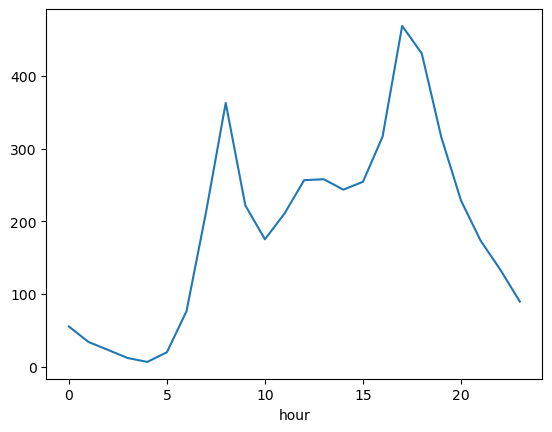

In [9]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

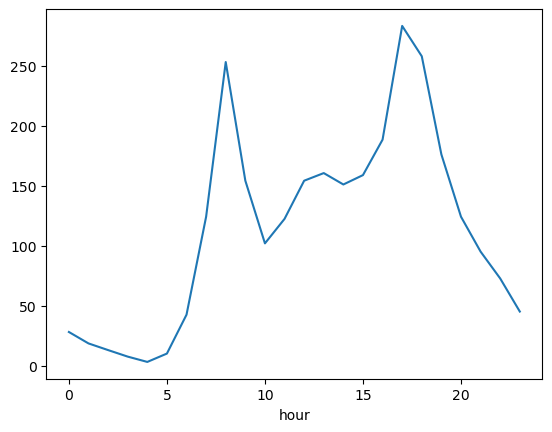

In [10]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
Invierno = bikes[bikes["season"] == 1]
Invierno.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

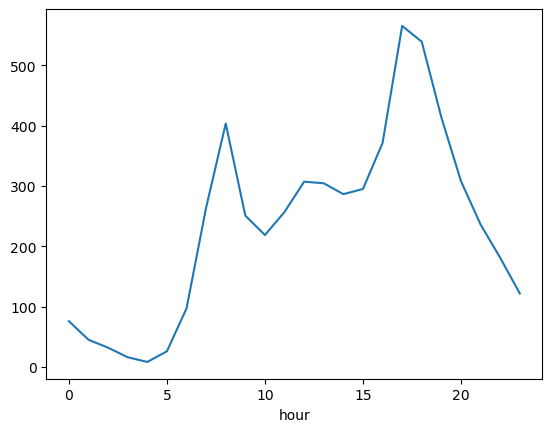

In [11]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
Verano = bikes[bikes["season"] == 3]
Verano.groupby('hour').total.mean().plot()

#### Renta promedio de bicicletas por hora en invierno y verano

como se observa en los gráficos realizados, sin importar si es invierno o verano, el promedio de renta de bicicletas es bajo entre las 0 y las 6, luego presenta un aumento significativo con pico a las 8 y disminuye ligeramente entre las 10 y las 15, luego aumento nuevamente y presente el pico máximo sobre las 17, después del cual comienza a disminuir nuevamente, este comportamiento se considera coherente con las dinámicas de movilidad en ciudad y las horas pico. La principal diferencia que se observa es que la renta promedio de bicicletas es mucho menor durante invierno y que en esta temporada los picos que se registra a las 8 y a las 15 son mucho más cercanos.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [179]:
# Celda 3
## Importamos las libterias necesarias
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Convertimos la variable "season" en dummy
bikes['season'] = bikes['season'].astype(object)
bikes_dummy = pd.get_dummies(bikes, columns=['season'], drop_first=True)

## División de datos en entrenamiento y prueba
X = bikes_dummy[['season_2', 'season_3','season_4','hour']]
y = bikes_dummy['total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Creación y ajuste del modelo
model = LinearRegression()
model.fit(X_train, y_train)

## Coeficientes del modelo
print(model.coef_)

### Predicciones
y_pred = model.predict(X_test)

# Evaluación del modelo
print("R2:",r2_score(y_test, y_pred))
from sklearn.metrics import mean_squared_error
print("MSE:",mean_squared_error(y_test, y_pred, squared=True))

[ 95.37267992 118.94705421  81.8012243   10.64406679]
R2: 0.21915721062519355
MSE: 26626.843544254338


#### Análisis del modelo de regresión lineal
Según los resultados obtenidos en el modelo de regresión lineal, manteniendo la hora constante cuando la temporada es primavera "2" el alquiler de biciletas aumenta aproximadamente en 95, cuando es verano "3" aumenta aproximadamente en 119 y cuando es otoño "a" aumenta aproximadamente en 82. Por otra parte, manteniendo la temporada constante, cada aumento de 1 hora incrementa aproximadamente en 11 el toal de alquiler de bicicletas.
Por otra parte, como se observa este modelo tiene un ajuste bajo. Una de las principales limitaciones de este modelo es que la variable respuesta no presenta un comportamiento lineal con respecto a las variables predictoras, lo cual hace que su desempeño sea muy bajo con un R2 de 21,9 % y un MSE de 26627, además que se requiere transformar la variable "season" a dummy.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [188]:
################## PRUEBA INICIAL PARA LA VARIABLE "HOUR" #############

# Separación de variables predictoras (X) y variable de interes (y)
feature_cols=['season','hour']
X = bikes[feature_cols]
y = bikes['total']

## Dividir la base de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Se seleccionará una profundidad máxima de 3
max_depth = 3
num_pct = 10

## Seleccionamos la variable hour
j = 1
print(X.columns[j])

### Posibles puntos de corte para la variable hour
splits = np.percentile(X_train.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
splits

##### PRIMERA PRUEBA: tomaremos la posición de corte 5 #####
k=5
filter_l = X_train.iloc[:, j] < splits[k]
y_l_train = y_train.loc[filter_l]
y_r_train = y_train.loc[~filter_l]

### Dividimos los datos de test con la misma condición
filter_l = X_test.iloc[:, j] < splits[k]
y_l_test = y_test.loc[filter_l]
y_r_test = y_test.loc[~filter_l]

### Creamos la función de BEST_MSE
def mse(X,y,split):
    y_l = y[X < split]
    y_r = ~y_l
    if len (y_l) == 0 or len(y_r) == 0:
        return float('inf')
    mse_l = mean_squared_error(y_l, [np.mean(y_l)]*len(y_r))
    mse_r = mean_squared_error(y_r, [np.mean(y_r)]*len(y_r))
    return (mse_l*len(y_l)+mse_r*len(y_r))/len(y)

hour


In [200]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10): 
    features = range(X.shape[1])
    best_split = [0, 0, float('inf')]  # j, split, mse_value
    for j in features:  
       splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
       splits = np.unique(splits)[1:]
        
       for split in splits:
           mse_value = mse(X.iloc[:,j], y,split)
           if mse_value < best_split[2]:
               best_split = [j, split, mse_value]
    return best_split  

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y,level=0, max_depth=10, num_pct=10):
    
    # Calcular la mejor división
    j, split, mse_value = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y_train.mean()
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0])
    # Revisar el criterio de parada 
    if level >= max_depth:
        return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]

    ## verficar si hay suficientes observaciones en las ramas
    if X_l.shape[0] == 0 or X_r.shape[0] == 0:
        return tree
        
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_l, y_l, level + 1, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [201]:
tree = tree_grow(X_train,y_train, num_pct=10)
tree

{'y_pred': 190.06109324758842,
 'level': 0,
 'split': [1, 2.0],
 'n_samples': 8708,
 'sl': {'y_pred': 190.06109324758842,
  'level': 1,
  'split': [0, 2.0],
  'n_samples': 723,
  'sl': {'y_pred': 190.06109324758842,
   'level': 2,
   'split': [1, 1.0],
   'n_samples': 173,
   'sl': {'y_pred': 190.06109324758842,
    'level': 3,
    'split': -1,
    'n_samples': 83},
   'sr': {'y_pred': 190.06109324758842,
    'level': 3,
    'split': -1,
    'n_samples': 83}},
  'sr': {'y_pred': 190.06109324758842,
   'level': 2,
   'split': [1, 1.0],
   'n_samples': 173,
   'sl': {'y_pred': 190.06109324758842,
    'level': 3,
    'split': -1,
    'n_samples': 83},
   'sr': {'y_pred': 190.06109324758842,
    'level': 3,
    'split': -1,
    'n_samples': 83}}},
 'sr': {'y_pred': 190.06109324758842,
  'level': 1,
  'split': [0, 2.0],
  'n_samples': 723,
  'sl': {'y_pred': 190.06109324758842,
   'level': 2,
   'split': [1, 1.0],
   'n_samples': 173,
   'sl': {'y_pred': 190.06109324758842,
    'level': 3,


In [202]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


In [203]:
y_pred = tree_predict(X_test, tree, proba=False)
print("MSE:",mean_squared_error(y_test, y_pred, squared=True))

MSE: 34157.3238496641


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

,feature,importance
0,season,0.206973
1,hour,0.793027


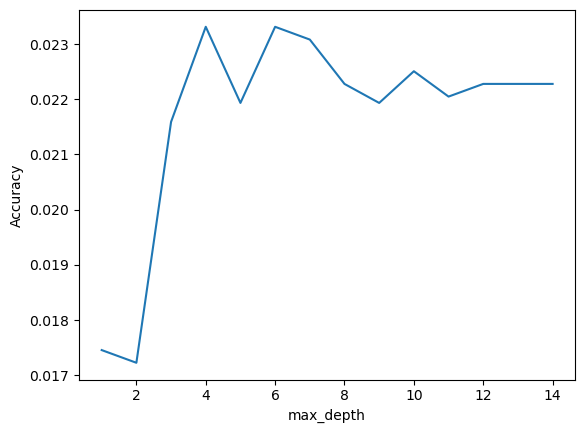

In [176]:
# Separación de variables predictoras (X) y variable de interes (y)
feature_cols=['season','hour']
X = bikes[feature_cols]
y = bikes['total']

## Dividir la base de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 15)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

# Gráfica max_depth versus RMSE (error del modelo)
import matplotlib.pyplot as plt
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=4, random_state=1)
clf.fit(X, y)

# Uso de la función .feature_importances_ para obtener la importancia de cada variable
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

In [177]:
dt_regressor = DecisionTreeRegressor(max_depth=depth,random_state = 1)
dt_regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=14, random_state=1)

In [178]:
from sklearn.metrics import r2_score
y_pred = dt_regressor.predict(X_test)
print("R2:",r2_score(y_test, y_pred))
print("MSE:",mean_squared_error(y_test, y_pred, squared=True))

R2: 0.6184593633759717
MSE: 13010.586734491499


#### Desempeño del árbol de regresión
según los resultados obtnenidos, el árbol de regresión obtuvo un desempeño mucho mejor, ya que el R2 aumentó a 61,8 % y el MSE disminuyó aproximadamente la mitad a 13011. 

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [5]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [6]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [7]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [79]:
# Celda 6
### Arbol de decisión
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 11)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

### Ajuste del modelo y predicciones
clf = DecisionTreeClassifier(max_depth=2, random_state=1)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

### Evaluación del modelo
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))


#### Construcción del modelo de regresión logística
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=1)

# Ajustar el modelo
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

### Evaluación del modelo
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.6453333333333333
0.6448598130841121
0.614
0.6106254203093476


In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [14]:
# Celda 7

########################## ENSAMBLAJE MANUAL ########################################

# Creación de 100 muestras de bootstrap
n_estimators = 100
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

# Entrenamiento de 100 modelos con las 100 muestras boostrap de árbol de decisión con max_depth= 3
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)
trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_depth=3, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    
# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

# Entrenamiento de 100 modelos con las 100 muestras boostrap de árbol de decisión con min_samples_leaf=10
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)
trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(min_samples_leaf = 10, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    
# Predicción para los datos del set de test con cada modelo
y_pred_df2 = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df2.iloc[:, i] = trees[i].predict(X_test)

y_pred_df2.head()

# Entrenamiento de 100 modelos con las 100 muestras boostrap con regresión logística
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)
trees = {}
for i in range(n_estimators):
    trees[i] = LogisticRegression(random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    
# Predicción para los datos del set de test con cada modelo
y_pred_df3 = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df3.iloc[:, i] = trees[i].predict(X_test)

y_pred_df3.head()

## Unión de todas las predicciones
y_pred_dfT = pd.concat([y_pred_df, y_pred_df2, y_pred_df3], axis=1)
y_pred_dfT.head(5)

# Votación mayoritaria
y_pred = []
for i in range(len(y_pred_dfT)):
    if y_pred_dfT.iloc[i,:].sum() >= 150:
        y_pred.append(1)
    else:
        y_pred.append(0)

# Desempeño al hacer votación mayoritaria
print(accuracy_score(y_pred, y_test),f1_score(y_pred, y_test))

0.6333333333333333 0.6278755074424899


In [15]:
################## ENSAMBLAJE DE ENSAMBLAJES #####################

# Definición del modelo BaggingClassifier de la libreria sklearn
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
clf2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=10), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
clf3 = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

## Modelo de árbol de decisión con max_depth = 3
clf.fit(X_train, y_train)
y_pred1 = clf.predict(X_test)
print(accuracy_score(y_pred1, y_test),f1_score(y_pred1, y_test), )

## Modelo de árbol de decisión con min_samples_leaf=10
clf2.fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)
print(accuracy_score(y_pred2, y_test),f1_score(y_pred2, y_test))

## Modelo de regresión logística
clf3.fit(X_train, y_train)
y_pred3 = clf3.predict(X_test)
print(accuracy_score(y_pred3, y_test),f1_score(y_pred3, y_test))

## Data frame con las estimaciones de los tres modelos
y_pred_df = pd.DataFrame()
y_pred_df['indíce']= X_test.index
y_pred_df['Prediccion1'] = pd.Series(y_pred1)
y_pred_df['Prediccion2'] = pd.Series(y_pred2)
y_pred_df['Prediccion3'] = pd.Series(y_pred1)
y_pred_df.set_index('indíce',drop = True, inplace = True)

# Votación mayoritaria
y_pred = []
for i in range(len(y_pred_df)):
    if y_pred_df.iloc[i,:].sum() >= 2:
        y_pred.append(1)
    else:
        y_pred.append(0)

## Evaluación del desempeño
print(accuracy_score(y_pred, y_test),f1_score(y_pred, y_test))

0.6446666666666667 0.6376614547926581
0.656 0.6596306068601584
0.618 0.613099257258609
0.6446666666666667 0.6376614547926581


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [16]:
# Celda 8
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB MODELO 1
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha1 = (1 - errors) / (1 - errors).sum()
y_pred1 = (np.sum(y_pred_all_ * alpha1, axis=1) >= 0.5).astype(int)

# Desempeño al hacer votación ponderada
print(accuracy_score(y_pred1, y_test),f1_score(y_pred1, y_test))

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB MODELO 2
errors = np.zeros(clf2.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf2.n_estimators))

for i in range(clf2.n_estimators):
    oob_sample = ~clf2.estimators_samples_[i]
    y_pred_ = clf2.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf2.estimators_[i].predict(X_test)
    
alpha2 = (1 - errors) / (1 - errors).sum()
y_pred2 = (np.sum(y_pred_all_ * alpha2, axis=1) >= 0.5).astype(int)

# Desempeño al hacer votación ponderada
print(accuracy_score(y_pred2, y_test),f1_score(y_pred2, y_test))

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB MODELO 3
errors = np.zeros(clf3.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf3.n_estimators))

for i in range(clf3.n_estimators):
    oob_sample = ~clf3.estimators_samples_[i]
    y_pred_ = clf3.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf3.estimators_[i].predict(X_test)
    
alpha3 = (1 - errors) / (1 - errors).sum()
y_pred3 = (np.sum(y_pred_all_ * alpha3, axis=1) >= 0.5).astype(int)

# Desempeño al hacer votación ponderada
print(accuracy_score(y_pred3, y_test),f1_score(y_pred3, y_test))

0.6446666666666667 0.638153428377461
0.6553333333333333 0.6523201075991929
0.6186666666666667 0.6140350877192983


In [23]:
### Cálculo del modelo de ensamblaje 
from sklearn.ensemble import VotingClassifier
eclf2 = VotingClassifier(estimators=[('árbol_1', clf), ('árbol_2', clf2), ('regLog', clf3)], voting='soft', weights=[1,1,1])
eclf2.fit(X_train, y_train)

## Predicción
y_pred = eclf2.predict(X_test)
# Desempeño al hacer votación ponderada
print(accuracy_score(y_pred, y_test),f1_score(y_pred, y_test))

0.6566666666666666 0.656437625083389


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

### Votación mayoritaria
Según los resultados obtenidos, al realizar el proceso de Bagging por votación mayoritaria los mejores resultados se obtuvieron con los 100 modelos de árbol de decisión con restricción de min_samples_leaf = 10, ya que se obtuvo un accuracy de 65,60 % y un f1_score de 65,96 %, se resalta que en este caso el ensamblaje de los tres modelos no generó mejores resultados, ya que con el ensamblaje de las 300 muestras el accuracy fue de 63,33 % y el f1 score de 62,79 % y con el ensamblaje de los tres ensamblajes el accuracy fue de 64,47 % y el f1 score de 63,77 %.

### Votación ponderada
Según los resultados obtenidos, en el ensamblaje por votación ponderada, los mejores resultados se obtienen en el ensamblaje global, con un accuracy de 65,67 % y un f1 score de 65,64 %, mientras que en los modelos individuales, los mejores resultados se obtuvieron al igual que en el caso anterior con los 100 modelos de árbol de decisión con restricción de min_samples_leaf = 10 que presentó un accuracy de 65,53 % y un f1 score de 65,23 %.

Al comparar ambas metodologías se osberva que los resultados son bastantes similares, sin embargo se presenta un leve aumento en las metricas de desempeño al realizar la estimación por votación ponderada.